# Response time minimization - Finnmark police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

#### Finnmark police district
Finnmark is the country's northernmost police district, with a scattered population, great distances and a harsh climate. Finnmark police district is Norway's second largest, with an area of ​​48,631 km2. With a population of around 76,000, it is also the country's smallest police district in terms of population.


In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-13T21:23:42.619444+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp
import highspy
import folium
import utilityModule # own custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

matplotlib: 3.8.3
numpy     : 1.26.4
pyproj    : 3.6.1
geopandas : 0.14.3
networkx  : 3.2.1
pandana   : 0.7
osmnx     : 1.9.1
shapely   : 2.0.3
pulp      : 2.8.0
folium    : 0.16.0
pandas    : 2.2.1
highspy   : 1.5.3



## 0. Load road network

We load a road network of Oslo police district that has been preprocessed.
- Network type: drive
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node centrality measures has already been calculated for the network and stored as a CSV file.

In [3]:
### Load road network file of Øst police district, Norway
# Read from local path
Finnmark_filepath = "../data/Finnmark/FinnmarkDriveImputed.graphml" # with travel time attribute
Finnmark_graph = ox.load_graphml(Finnmark_filepath) # originally in WGS84 (EPSG:4326)

Type of Finnmark_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Finnmark_graph:  EPSG:32633


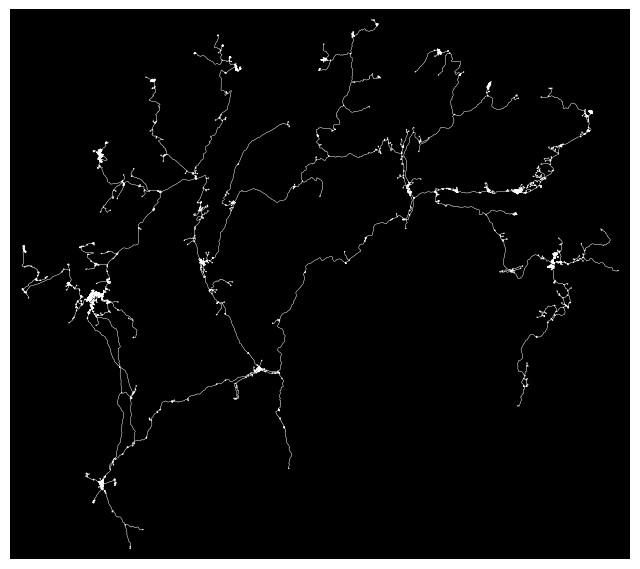

In [4]:
Finnmark_graph = ox.projection.project_graph(Finnmark_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of Finnmark_graph: {type(Finnmark_graph)}")
print(f"CRS of Finnmark_graph:  {Finnmark_graph.graph['crs']}")

# plot graph
fig, ax = ox.plot_graph(Finnmark_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Finnmark_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u          v          key                                                      
6649853654 6649853802 0    [544799255, 321217143, 289301655, 479869082, 5...   
6649853802 6649857141 0                    [479870568, 479870565, 289301653]   

                                                      name  \
u          v          key                                    
6649853654 6649853802 0    [Šuolggajohnjálbmi, Áhpemohkki]   
6649853802 6649857141 0                    Bieskkángeaidnu   

                                            highway maxspeed  oneway reversed  \
u          v          key                                                       
6649853654 6649853802 0    [unclassified, tertiary]       80   False     True   
6649853802 6649857141 0                    tertiary       80   False    False   

                             length  \
u          v          key             
6649853654 6649853802 0   11112.143   
6649853802 6649857141 0    1274.426   

                                                                    geometry  \
u          v          key                                                      
6649853654 6649853802 0    LINESTRING (896187.767 7724873.040, 896190.153...   
6649853802 6649857141 0    LINESTRING (897188.363 7732497.288, 897171.562...   

                           speed_kph  travel_time bridge  ref lanes width  \
u          v          key                                                   
6649853654 6649853802 0       80.000      500.000    NaN  NaN   NaN   NaN   
6649853802 6649857141 0       80.000       57.300    yes  NaN   NaN   NaN   

                          junction access tunnel est_width  
u          v          key                                   
6649853654 6649853802 0        NaN    NaN    NaN       NaN  
6649853802 6649857141 0        NaN    NaN    NaN       NaN

In [6]:
nodes.head(2) # verify nodes contain x and y coordinates

y          x  street_count    lon    lat highway  \
osmid                                                                   
6649853654 7724873.040 896187.767             1 25.100 69.338     NaN   
6649853802 7732497.288 897188.363             3 25.157 69.404     NaN   

                                  geometry  
osmid                                       
6649853654  POINT (896187.767 7724873.040)  
6649853802  POINT (897188.363 7732497.288)

In [7]:
# print number of nodes and edges
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")

Number of nodes: 5287
Number of edges: 12526


## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based purely on population count. Should fall in range [2000,2500]  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB - Oslo police district.
- Correct extent: Combined municipalities of  Asker, Bærum and Oslo.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [8]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Finnmark_polygon_path = "../data/Finnmark/FinnmarkCombinedPolygon.geojson"
Finnmark_polygon_gdf = gpd.read_file(Finnmark_polygon_path)
Finnmark_polygon_gdf = Finnmark_polygon_gdf.to_crs(Finnmark_graph.graph['crs']) # convert to same CRS as the road network

In [9]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Finnmark/FinnmarkPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Finnmark_graph.graph['crs']) # convert to same CRS as the road network

In [10]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  28267507661000           2   
1  28265007661000           2   

                                            geometry  
0  POLYGON ((826749.995 7660999.998, 826749.995 7...  
1  POLYGON ((826499.995 7660999.998, 826499.995 7...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range of [2000,2500].

In [11]:
# calculate the number of points to simulate in each grid cell - vectorized version
simulated_events_dict = utilityModule.simulate_event_points(population_gdf, pop_std_multiplier=0.006172363281250001, min_range=1500, max_range=1550)
population_gdf = simulated_events_dict["population_gdf"]

Total number of simulated event points: 1548. Target range [1500, 1550], using population multiplier: 0.025750000000000002
 Correction factor: 0.006172363281250001/0.025750000000000002 = 0.23970342839805828


In [12]:
# print the number of cells with 0, 1, 2, ..., 9 events
for i in range(0, 7):
    print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Nr of cells with 0 events: 3576
Nr of cells with 1 events: 450
Nr of cells with 2 events: 200
Nr of cells with 3 events: 109
Nr of cells with 4 events: 63
Nr of cells with 5 events: 12
Nr of cells with 6 events: 7


id  population  \
3497  28197507862500         374   
3512  28202507863000         287   
913   28147507784250         235   

                                               geometry  num_points  
3497  POLYGON ((819749.992 7862499.997, 819749.992 7...          10  
3512  POLYGON ((820249.991 7862999.997, 820249.991 7...           7  
913   POLYGON ((814749.995 7784249.998, 814749.995 7...           6

In [13]:
%%time
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 203 ms
Wall time: 295 ms


geometry
0  POINT (820886.465 7674405.738)
1  POINT (820872.873 7674875.411)
2  POINT (820907.437 7675044.904)

In [14]:
# print number of nodes
print(f"Number of nodes: {len(nodes)}")

Number of nodes: 5287


In [15]:
# print(f"Number of nodes: {len(nodes)}")
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=9.1e-12, simplification_tolerance=5.0, plot_results=False)

Density: Min: 9.693e-24 | Median: 4.842e-12 | Mean: 9.903e-12 | Max: 9.832e-11


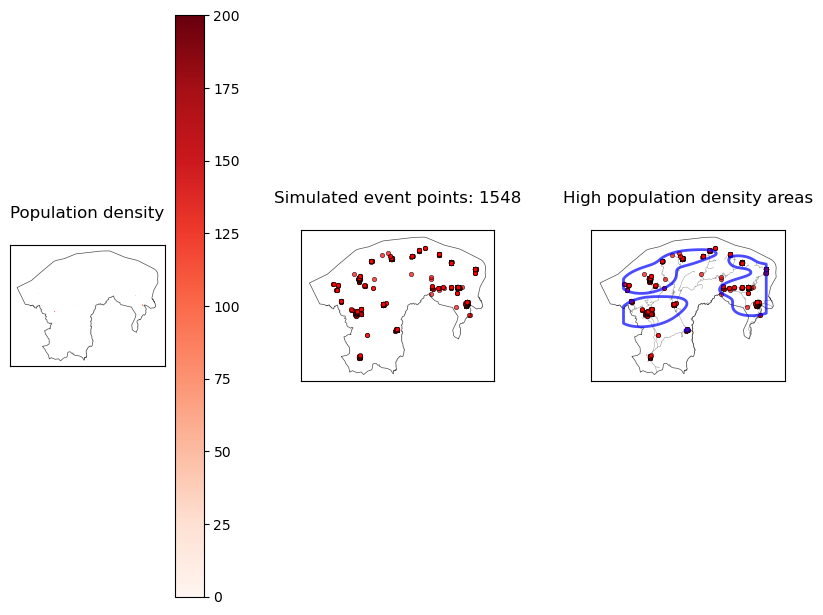

In [16]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Finnmark_polygon_gdf, population_gdf, event_points_gdf, high_pop_density_area, edges)

*(Skip using this kernel density function to constrain the sampling of car nodes)*

Function show stability issues for several districts.

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measure as node attribute  
2.2 Sample candidate points and filter out poor candidate points

In [17]:
nodes.head(2)

y          x  street_count    lon    lat highway  \
osmid                                                                   
6649853654 7724873.040 896187.767             1 25.100 69.338     NaN   
6649853802 7732497.288 897188.363             3 25.157 69.404     NaN   

                                  geometry  
osmid                                       
6649853654  POINT (896187.767 7724873.040)  
6649853802  POINT (897188.363 7732497.288)

### 2.1 Add Centrality measure as node attribute

Next we load the pre-computed closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network.   
It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

In [18]:
# import node closeness centrality from file
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

nodes_centrality_import = pd.read_csv("../data/Finnmark/FinnmarkNodeCentrality.csv")

In [19]:
# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')
print(f"Number of nodes: {len(nodes)}")
nodes.head(2)


Number of nodes: 5287


y          x  street_count    lon    lat highway  \
0  7724873.040 896187.767             1 25.100 69.338     NaN   
16 7732497.288 897188.363             3 25.157 69.404     NaN   

                          geometry       osmid  closeness_centrality  \
0   POINT (896187.767 7724873.040)  6649853654                 0.000   
16  POINT (897188.363 7732497.288)  6649853802                 0.000   

    betweenness_centrality  
0                    0.000  
16               63364.000

In [20]:
# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count    lon    lat highway  \
osmid                                                                   
6649853654 7724873.040 896187.767             1 25.100 69.338     NaN   
6649853802 7732497.288 897188.363             3 25.157 69.404     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
6649853654  POINT (896187.767 7724873.040)                 0.000   
6649853802  POINT (897188.363 7732497.288)                 0.000   

            betweenness_centrality  
osmid                               
6649853654                   0.000  
6649853802               63364.000

Now, that the closeness centrality is added as an attribute to the ``nodes`` GeoDataFrame, we can use this to filter out better candidate locations for the police cars.

In [21]:
# # inspect stats for columns closeness_centrality and betweenness_centrality
# print(f"Stats for closeness_centrality:\n{nodes['closeness_centrality'].describe()}")
# print(f"Stats for betweenness_centrality:\n{nodes['betweenness_centrality'].describe()}")


### 2.2 Sample candidate points and filter out poor candidate points

#### Steps:
1. Sample a set of random points from the road network (using the high population density areas as a polygon).
2. Filter out points that are too close to the border of the road network (closeness centrality threshold).
3. Filter out points that are too close to each other.
4. Filter out points that are too close to the existing police stations.

In [22]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
# car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = nodes.copy()
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED, replace=False)
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 5287, nr of police car nodes: 100


y           x  street_count    lon    lat highway  \
osmid                                                                    
7295496345 7802808.165 1075465.367             3 29.988 69.694     NaN   
7295497184 7820284.347 1043166.090             3 29.285 69.914     NaN   

                                   geometry  closeness_centrality  \
osmid                                                               
7295496345  POINT (1075465.367 7802808.165)                 0.000   
7295497184  POINT (1043166.090 7820284.347)                 0.000   

            betweenness_centrality  
osmid                               
7295496345                   0.000  
7295497184             5898102.000

Input nr of car nodes: 100
Remaining nr of car nodes: 90, after discarding the 10 (10%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


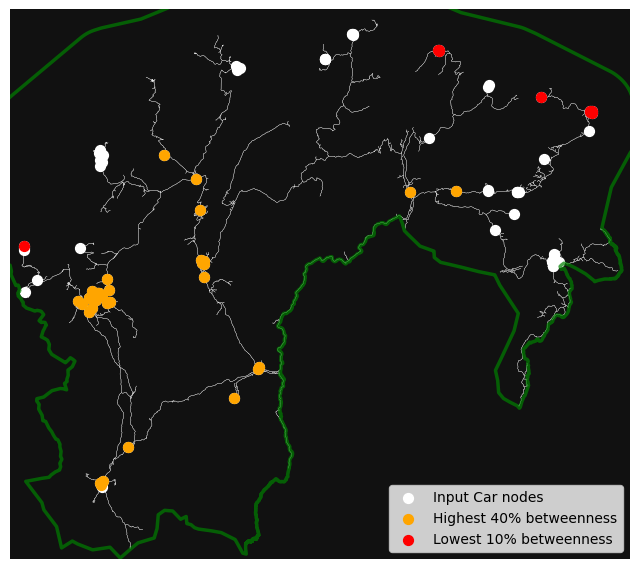

In [23]:
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Finnmark_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.10, input_graph=Finnmark_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 90
Remaining nr of car nodes: 50, after discarding the 40 (45%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


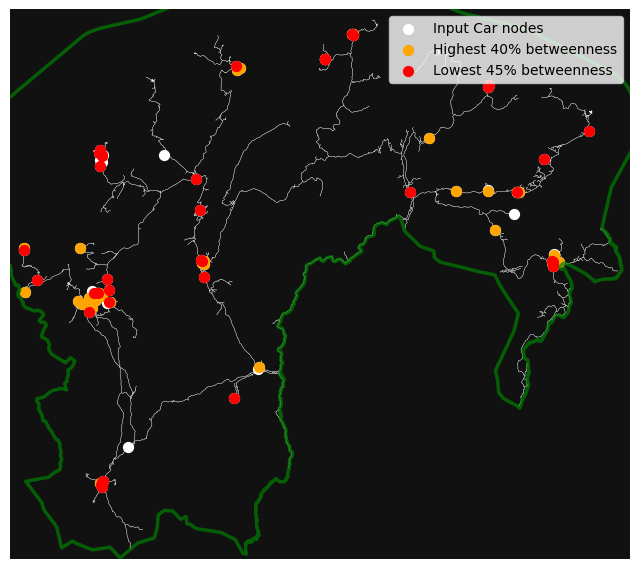

In [24]:
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Finnmark_polygon_gdf, top_percent=0.4, bottom_percent=0.45, 
                                                            input_graph=Finnmark_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 50
Remaining nr of car nodes: 19, after removing the 31 nodes that are within 15000 m of each other



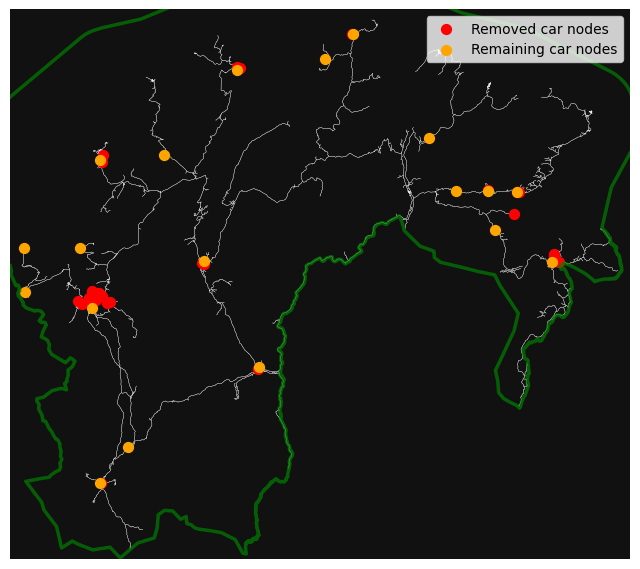

In [25]:
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Finnmark_polygon_gdf, 
                        min_distance=15000, input_graph=Finnmark_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [26]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()
# nodes = nodes.reset_index()

# create network with pandana
Finnmark_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Finnmark_network_pdna: {type(Finnmark_network_pdna)}")
print(f"Network nodes:")
Finnmark_network_pdna.nodes_df.head(2)

type of Finnmark_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                            
6649853654 896187.767 7724873.040
6649853802 897188.363 7732497.288

In [27]:
print(f"Network edges: ")
Finnmark_network_pdna.edges_df.head(2)

Network edges: 


from          to    length  travel_time
0  6649853654  6649853802 11112.143      500.000
1  6649853802  6649857141  1274.426       57.300

In [28]:
# %%time
# Finnmark_network_pdna.precompute(3000)

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network. Therefore, we need to snap the event points to the Pandana network.

In [29]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Finnmark_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry   nearest_node          x           y
0  POINT (820886.465 7674405.738) 2044453178.000 820928.735 7674317.901
1  POINT (820872.873 7674875.411) 2038906536.000 820751.296 7674899.914

In [30]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Finnmark_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Finnmark_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([2168865729, 5870888334, 7295497184, 7295496808, 5870901748],
      dtype=int64)

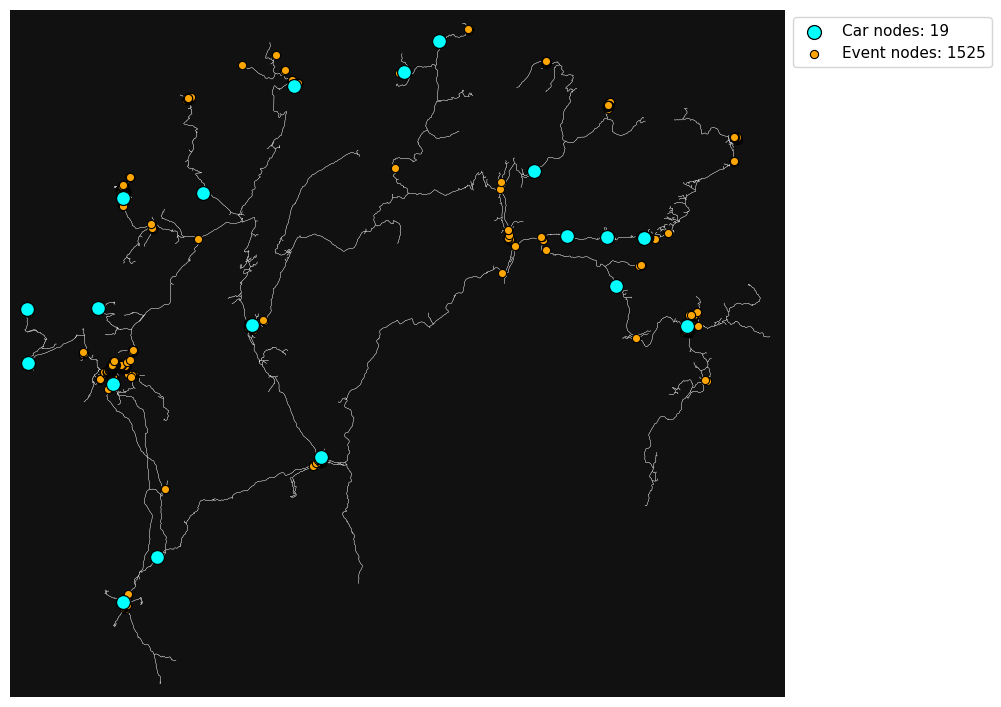

In [31]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(Finnmark_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

First, identify the nearest node to each Police car and Event.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [32]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [33]:
%%time
# distance between each possible pair of facilities-clients combination
distances = Finnmark_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = Finnmark_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(travel_times))
print("Number of travel_times calculated: ", len(travel_times))
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

<class 'list'>
Number of travel_times calculated:  28975
5 first origin-destination distances [m]     : [118660.492, 117189.782, 117057.258, 116981.733, 116780.081]
5 first origin-destination travel times [sec]: [6079.1, 5980.6, 5990.6, 5976.6, 5959.9]
CPU times: total: 453 ms
Wall time: 56.3 ms


In [34]:
# print the statistics for distances and travel times
# print("Distances statistics:")
# print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())


Travel times statistics:
count   28975.000
mean    13658.111
std      7449.288
min         0.000
25%      7221.650
50%     13220.199
75%     20175.100
max     30934.700
dtype: float64


In [35]:
# Restructure the distances and travel times arrays into a DataFrame (CFinnmark Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix.head(2)

distance  travel_time   carNodeID  eventNodeID
0 118660.492     6079.100  2168865729   2044453178
1 117189.782     5980.600  2168865729   2038906536

In [36]:
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time   carNodeID  eventNodeID          x           y
0 118660.492     6079.100  2168865729   2044453178 820928.735 7674317.901
1 117189.782     5980.600  2168865729   2038906536 820751.296 7674899.914

In [37]:
# Save cFinnmark matrix to CSV
CostMatrix.to_csv("../data/Finnmark/FinnmarkCostMatrix.csv", index=False)

# # import cFinnmark matrix from CSV
# CostMatrix_imported = pd.read_csv("../data/Finnmark/FinnmarkCostMatrix.csv")
# CostMatrix_imported.head(2)

CostMatrix.drop(columns="distance", inplace=True)

Now, we have made Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data structures for efficient computation

In [39]:
%%time
# find the total number of unique events from the reduced cFinnmark matrix
nr_of_unique_events = CostMatrix['eventNodeID'].nunique()
print(f"Total number of unique events: {nr_of_unique_events}")

# Preprocess the cFinnmark matrix
# 1) Convert to a dictionary for fast lookup
# 2) Reduce problem size: Remove top x% travel times, as there is probably a closer car to the event
DISCARD_THRESHOLD = 0.40
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Total number of unique events: 1207
Filtering out 40% highest travel times - keeping only travel times <= 16982 sec, or 283.0 min
Original nr of pairs: 22933 | Filtered nr of pairs: 13760
Original max travel time: 30934.7 | Filtered max travel time: 16980.1
Original min travel time: 0.0 | Filtered min travel time: 0.0
CPU times: total: 15.6 ms
Wall time: 38.1 ms


### 5.2 Setup LP problem

In [40]:
# Constants
NR_OF_CARS = 4
CAR_CAPACITY = 450

# # Sets
P = CostMatrix['carNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 19
Number of events: 1207
Number of decision variables: 13779
Number of constraints: 14987
Number of non-zero coefficients: 13779
Number of non-zero coefficients in the objective function: 13757
PuLP Problem setup took 0.77 seconds


### 5.5 Run the solvers

- **PULP_CBC (COIN-OR Branch and Cut)** - open-source solver that is included in the PuLP package.
- **HiGHS (High-Performance Solver)** - a high-performance solver that use the HiGHS optimization engine.

1st run of each solver will relax the integer variable constraint (`mip=False`) for fast computation. 2nd run of each solver will use proper integer constraints (`mip=True`) to get the slow, final solution for verification.

*Recall this is a minimization problem, so the lower the objective value, the better the solution.*

In [41]:
# Inspect available pulp solvers
pulp.listSolvers(onlyAvailable=True)

['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'HiGHS']

In [42]:
%%time
# Run the solver
solve = utilityModule.run_solvers(problem, P, nr_of_locations=4, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")

Optimal police car locations found: 4/4 in 2.09 seconds: [2168865729 7295496808 5870901748 5815082746]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 3346613.8290 seconds, or 55776.90 minutes, or 929.61 hours
(Note: Currently reducing the Cost matrix by 40%)
CPU times: total: 750 ms
Wall time: 2.64 s


### 5.6 Extract results for inspection

In [43]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)

Optimal police car locations: dict_keys([2168865729, 7295496808, 5870901748, 5815082746])
Car 2168865729 is assigned 450/450 events
Car 7295496808 is assigned 160/450 events
Car 5870901748 is assigned 270/450 events
Car 5815082746 is assigned 327/450 events
Summing the events for each car gives 1207 events, which should equal the total number of unique events: 1207


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 19 | Optimal locations in solution: 4
- Events: 1207 | Max event capacity per police car: 450

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 3346614 sec | 55776.9 min | 929.61 hours

Car id: 2168865729 handles 450 events | Capacity: 100.00% | Total response time: 3288.65 min | Median: 2.98 min | Avg: 7.31 min
Car id: 7295496808 handles 160 events | Capacity: 35.56% | Total response time: 284.12 min | Median: 1.43 min | Avg: 1.78 min
Car id: 5870901748 handles 270 events | Capacity: 60.00% | Total response time: 5020.90 min | Median: 14.88 min | Avg: 18.60 min
Car id: 5815082746 handles 327 events | Capacity: 72.67% | Total response time: 4776.24 min | Median: 2.60 min | Avg: 14.61 min
Response time is multiplied by 0.24 to match the standard population_multiplier (median of all districts)


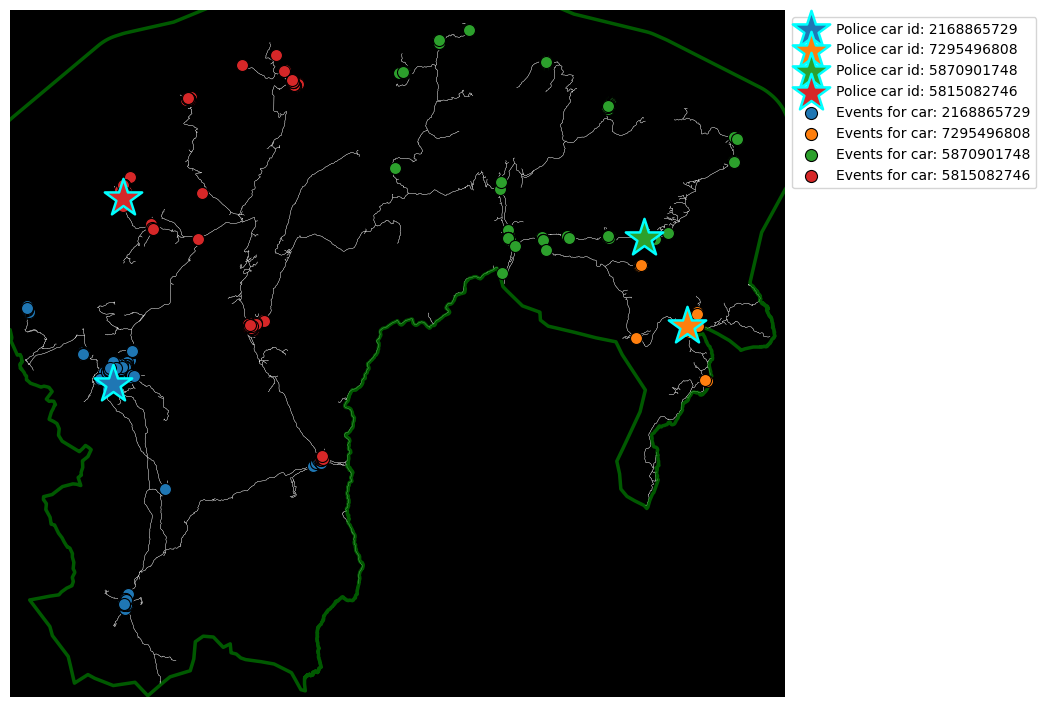

CPU times: total: 1.03 s
Wall time: 1.49 s


In [45]:
%%time
correction_factor = simulated_events_dict["correction_factor"]
utilityModule.plot_optimal_allocations(Finnmark_graph, Finnmark_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, correction_factor)

## 6.2 Visualize Isochrones - How far can you drive in different time intervals?
How far can you drive in 1.5, 4 and 8 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on travel time.  
We also, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [43]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 120]  # in minutes
ISO_COLORS = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges

Isochrone polygons for the travel times: [20, 60, 120] minutes


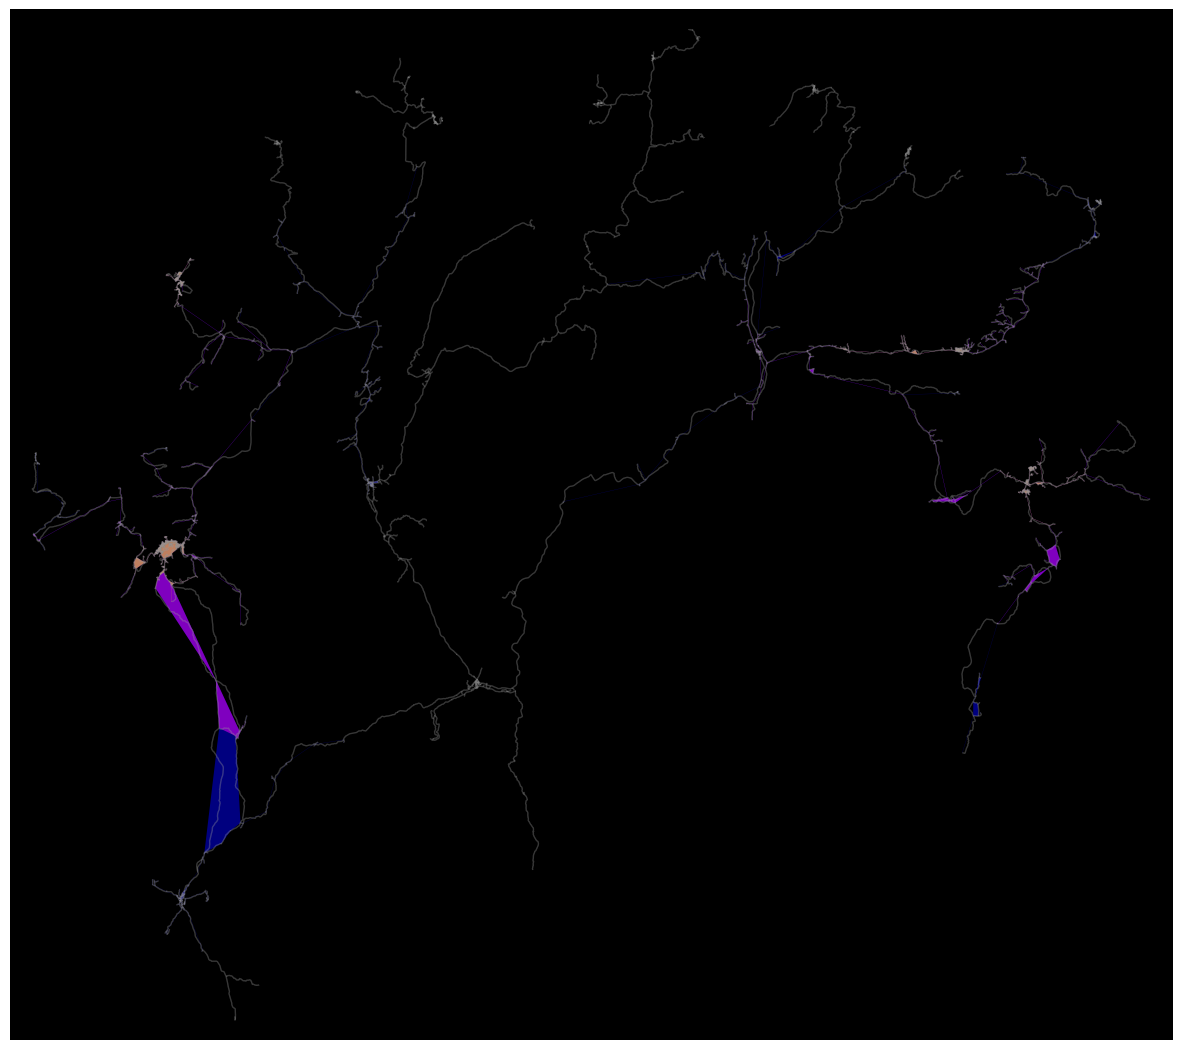

CPU times: total: 38.7 s
Wall time: 49.8 s


In [44]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Finnmark_graph, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=30, node_buff=0, infill=True)

# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(Finnmark_graph, isochrone_polys)

# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Finnmark_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
# iso_colors = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges
for merged_poly, color in zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS):
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=0.5, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=0.5, zorder=-1)
        ax.add_patch(patch)

print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

In [45]:
%%time
# Plot leaflet map
graph_map = utilityModule.plot_leaflet_map(Finnmark_graph, TRIP_TIMES, merged_isochrones, Finnmark_polygon_gdf, background_poly=True)
graph_map

CPU times: total: 1.05 s
Wall time: 1.74 s
